In [1]:
import mlflow
# import numpy as np
# import pandas as pd
# import pickle

# from sklearn.feature_extraction import DictVectorizer
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import root_mean_squared_error
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri("sqlite:///mlflow.db")

<h3>Q1. Install MLflow<h3>

In [2]:
# !pip install mlflow
!mlflow --version

mlflow, version 2.16.2


<h3>Q2. Download and preprocess the data<h3>

In [3]:
!python preprocess_data.py --raw_data_path ../test_data --dest_path ./output
!ls ./output

dv.pkl    test.pkl  train.pkl val.pkl


<h3>Q3. Train a model with autolog<h3>

In [4]:
!python train.py

2024/09/23 16:41:23 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
/opt/anaconda3/envs/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


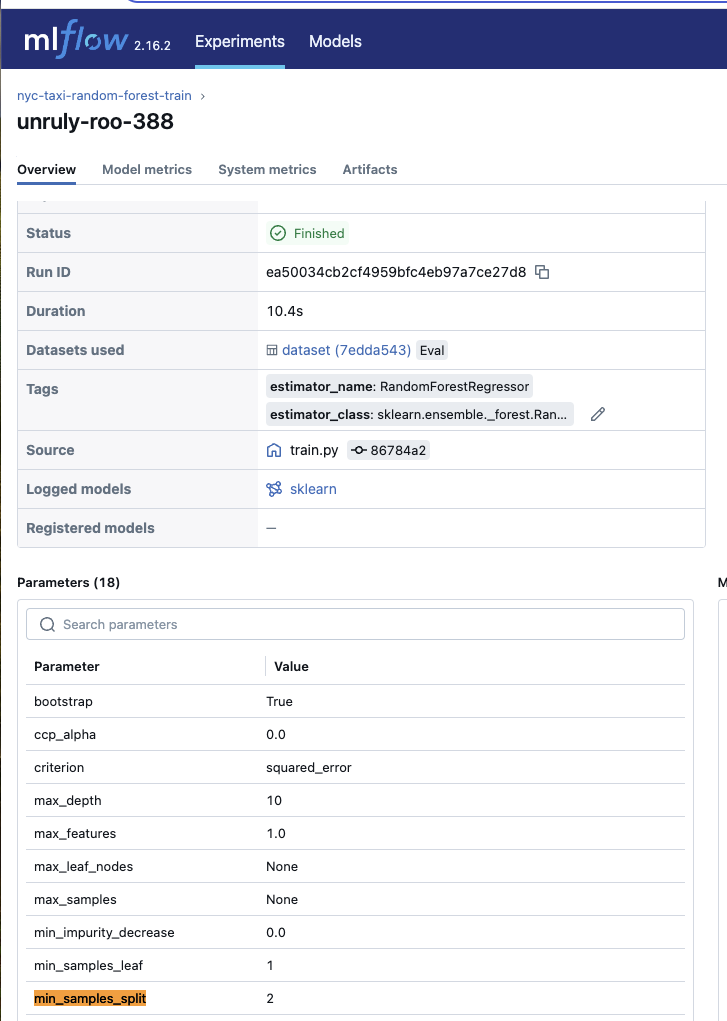

<h3>Q4. Launch the tracking server locally<h3>

In [9]:
!mlflow ui --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts

[2024-09-23 16:42:09 +0200] [98198] [INFO] Starting gunicorn 23.0.0
[2024-09-23 16:42:09 +0200] [98198] [INFO] Listening at: http://127.0.0.1:5000 (98198)
[2024-09-23 16:42:09 +0200] [98198] [INFO] Using worker: sync
[2024-09-23 16:42:09 +0200] [98199] [INFO] Booting worker with pid: 98199
[2024-09-23 16:42:09 +0200] [98200] [INFO] Booting worker with pid: 98200
[2024-09-23 16:42:10 +0200] [98201] [INFO] Booting worker with pid: 98201
[2024-09-23 16:42:10 +0200] [98202] [INFO] Booting worker with pid: 98202
^C
[2024-09-23 16:42:22 +0200] [98198] [INFO] Handling signal: int
[2024-09-23 16:42:22 +0200] [98200] [INFO] Worker exiting (pid: 98200)
[2024-09-23 16:42:22 +0200] [98201] [INFO] Worker exiting (pid: 98201)
[2024-09-23 16:42:22 +0200] [98199] [INFO] Worker exiting (pid: 98199)
[2024-09-23 16:42:22 +0200] [98202] [INFO] Worker exiting (pid: 98202)


<h3>Q5. Tune model hyperparameters<h3>

In [11]:
# !pip install hyperopt
!python hpo.py


  0%|                                    | 0/15 [00:00<?, ?trial/s, best loss=?]/opt/anaconda3/envs/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2024/09/23 16:43:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run chill-flea-518 at: http://127.0.0.1:5000/#/experiments/3/runs/ea40a6b3570a47c9bad3acc5434505c9.

2024/09/23 16:43:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3.

  7%|▋          | 1/15 [00:04<00:57,  4.12s/trial, best loss: 5.370086069268862]/opt/anaconda3/envs/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warn

In [12]:
HOP_EXPERIMENT = "nyc-taxi-random-forest-hyperopt"
client = MlflowClient()

experiment = client.get_experiment_by_name(HOP_EXPERIMENT)
best_run = client.search_runs(
    experiment_ids=experiment.experiment_id,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.rmse ASC"]
)[0]

print(f'Best validation RMSE is {best_run.data.metrics["rmse"]:.4}')

Best validation RMSE is 5.335


<h3>Q6. Promote the best model to the model registry<h3>

In [13]:
# !python register_model.py

model_name = 'nyc-rf-best-model'
model_version = 1

model_details = client.get_model_version(model_name, model_version)
run_id = model_details.run_id
run = client.get_run(run_id)
print(f'Test RMSE is {run.data.metrics["test_rmse"]:.4}')

Test RMSE is 5.567
